# Spectral relaxation for K-means clustering

Nikita Petrashen, Daniil Svirskiy, Nikita Drobyshev, Dinar Sharafutdinov

In [97]:
import numpy as np
import os
import pandas as pd
from sklearn import metrics
from sklearn.metrics.cluster import v_measure_score, homogeneity_completeness_v_measure
from sklearn.datasets import fetch_20newsgroups, make_blobs
from sklearn.datasets.base import get_data_home
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import SpectralClustering, KMeans, MiniBatchKMeans
import matplotlib.pyplot as plt
plt.xkcd()

### 20newsgroups

In [2]:
dataset = fetch_20newsgroups(subset='all', shuffle=True, random_state=42)

All categories

In [4]:
labels = dataset.target

In [5]:
labels.shape

(18846,)

In [6]:
np.unique(labels).shape[0]

20

In [0]:
['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

2 categories

In [13]:
categories = ['alt.atheism','comp.graphics']
dataset2 = fetch_20newsgroups(subset='all',
                             shuffle=True, random_state=42, categories = categories)
labels = dataset2.target
texts = dataset2.data
target = dataset2.target
number_of_clusters = 2

In [14]:
np.unique(labels).shape[0]

2

In [15]:
len(texts), len(target)

(1772, 1772)

In [16]:
texts[0]

"From: jliddle@rs6000.cmp.ilstu.edu (Jean Liddle)\nSubject: Re: HELP: Need 24 bits viewer\nOrganization: Illinois State University\nKeywords: 24 bit\nLines: 23\n\nIn article <1993Apr29.041601.8884@labtam.labtam.oz.au> graeme@labtam.labtam.oz.a\nu (Graeme Gill) writes:\n>In article <5713@seti.inria.fr>, deniaud@cartoon.inria.fr (Gilles Deniaud) writ\nes:\n>> Hi,\n>>\n>> I'm looking for a program which is able to display 24 bits\n>> images. We are using a Sun Sparc equipped with Parallax\n>> graphics board running X11.\n>\n>    xli, xloadimage or ImageMagick - export.lcs.mit.edu [18.24.0.12] /contrib\n>\n\nxv 3.0 (shareware) supports 24-bit displays, and has lots of other\nimprovements over earlier versions.  Definitely worth checking out\n(also at export)\n\nJean.\n-- \nJean Liddle                                 \nComputer Science, Illinois State University  \ne-mail:  jliddle@ilstu.edu                  \n--------------------------------------------\n"

In [17]:
vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(texts)

In [18]:
X.shape

(1772, 27756)

In [19]:
model = KMeans(n_clusters=number_of_clusters, 
               init='k-means++', 
               max_iter=100, 
               n_init=1)

model.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=100,
    n_clusters=2, n_init=1, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [20]:
X.shape

(1772, 27756)

In [22]:
random_state = 42

In [23]:
y_pred_texts = KMeans(n_clusters=number_of_clusters, random_state=random_state).fit_predict(X)

In [26]:
v_measure_score(target, y_pred_texts)

0.7772500533604567

In [28]:
metrics.completeness_score(target, y_pred_texts)

0.7829561746289551

In [29]:
metrics.silhouette_score(target.reshape(-1,1), y_pred_texts)

0.8789917637221477

### Test K-means for blobls

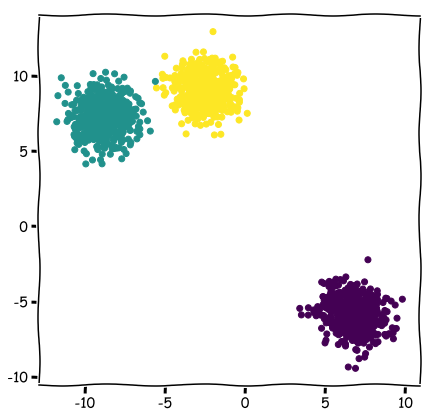

In [31]:
plt.figure(figsize=(15, 15))

n_clusters = 3
n_samples = 1500
X, y = make_blobs(n_samples=n_samples, random_state=random_state, n_features=6)
y_pred = KMeans(n_clusters=n_clusters, random_state=random_state).fit_predict(X)

plt.xkcd()
plt.subplot(221)
plt.scatter(X[:, 0], X[:, 1], c=y_pred)

In [32]:
X.shape

(1500, 6)

In [33]:
y_pred

array([2, 2, 2, ..., 1, 1, 2])

In [34]:
v_measure_score(y, y_pred)

1.0

In [35]:
y_pr = y_pred
y_pr[0] = 0

In [36]:
v_measure_score(y, y_pr)

0.9956219848839059

### p-K-means

In [37]:
A = X.T
AA = A.T @ A

In [38]:
AA.shape

(1500, 1500)

In [40]:
AA;

In [41]:
val, vect = np.linalg.eig(AA)

In [42]:
vect.shape

(1500, 1500)

In [46]:
np.flip(np.sort(np.abs(val)))[:10]

array([2.27763158e+05, 8.19542684e+04, 5.15776274e+04, 1.67292841e+03,
       1.52508629e+03, 1.48771492e+03, 1.88979682e-11, 1.88979682e-11,
       1.72362728e-11, 1.72362728e-11])

In [47]:
x_m_vect = np.argsort(val)[-n_clusters:]

In [48]:
new_X = vect[:, x_m_vect]
new_X.shape

(1500, 3)

In [50]:
new_X = np.abs(new_X)
new_X;

In [51]:
y_pred2 = KMeans(n_clusters=n_clusters, random_state=random_state).fit_predict(new_X)

In [52]:
v_measure_score(y, y_pred2)

0.8782105236855258

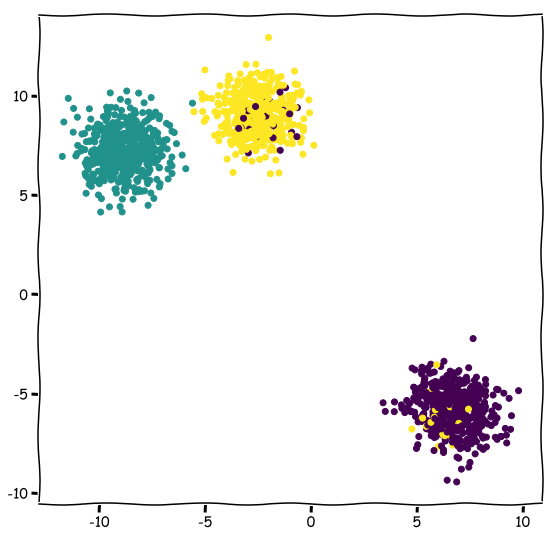

In [55]:
plt.figure(figsize=(9, 9))
plt.scatter(X[:, 0], X[:, 1], c=y_pred2)

For different amount of n_features

In [56]:
scores = []
n_f = []
for i in range(1, 25, 4):
  n_f.append(i)
  X, y = make_blobs(n_samples=n_samples, random_state=random_state, n_features=i)
  A = X.T
  AA = A.T @ A
  val, vect = np.linalg.eig(AA)
  x_m_vect = np.argsort(val)[-n_clusters:]
  new_X = vect[:, x_m_vect]
  new_X = np.abs(new_X)
  y_pred2 = KMeans(n_clusters=n_clusters, random_state=random_state).fit_predict(new_X)
  scores.append(v_measure_score(y, y_pred2))

In [57]:
scores

[0.30666099734759816,
 0.8096210505828637,
 0.8522458585682574,
 0.8170002256131205,
 1.0,
 1.0]

In [58]:
n_f

[1, 5, 9, 13, 17, 21]

Text(0.5, 0, 'number of features')

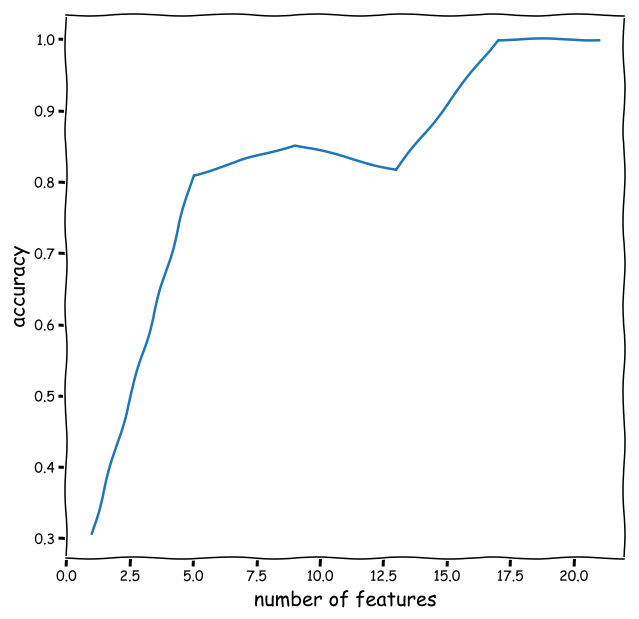

In [61]:
plt.figure(figsize=(10, 10))
plt.plot(n_f, scores, linewidth=2.5)
plt.ylabel(r"accuracy", fontsize=20)
plt.xlabel(r"number of features", fontsize=20)

We see that when the number of features becomes substantially bigger than the number of clusters, then the algorithm works well at least with synthetic data

### Let's use p-kmeans for 20newsgroups dataset

In [93]:
categories =['rec.motorcycles', 'rec.sport.baseball']
dataset2 = fetch_20newsgroups(subset='all',
                             shuffle=True, random_state=random_state, categories = categories)
texts = dataset2.data
target = dataset2.target
number_of_clusters = 2

vectorizer = TfidfVectorizer(stop_words='english', max_features=10000, norm = 'l2', max_df = 0.1, min_df = 6)
X = vectorizer.fit_transform(texts).toarray()

In [94]:
X.shape

(1990, 5610)

In [95]:
A = X.T
AA = A.T @ A
val, vect = np.linalg.eig(AA)
x_m_vect = np.argsort(val)[-number_of_clusters:]
new_X = vect[:, x_m_vect]
new_X = np.abs(new_X)
y_pred2 = KMeans(n_clusters=number_of_clusters, random_state=42).fit_predict(new_X)
v_measure_score(target, y_pred2)

0.02819917858609398

In [96]:
homogeneity_completeness_v_measure(target, y_pred2)

(0.015732793541401797, 0.13582252653917729, 0.02819917858609398)

By some reason p-k-means does not work with vectorised textual data, it seems that problem in vectorisation 

In [92]:
y_pred_texts = KMeans(n_clusters=number_of_clusters, random_state=42).fit_predict(X)
v_measure_score(target, y_pred_texts)

0.8728259418353201

### p-QR

In [68]:
def modified_gram_schmidt_qr(A):
    m = A.shape[0]
    n = A.shape[1]
    Q = A[:m, :min(m,n)].copy()
    R = np.zeros((min(m,n), n))
    Q[:, 0] = A[:, 0] / np.linalg.norm(A[:, 0])
    for i in range(min(m, n)):
        for j in range(i):
            Q[:, i] -= proj(Q[:, i], Q[:, j])      
        Q[:, i] = Q[:, i] / np.linalg.norm(Q[:, i])
        for k in range(i, n):
            R[i, k] = np.dot(Q[:, i], A[:, k])
            
    return Q, R

def proj(a, e):
    return e * np.dot(a, e)

def pivoted_QR(A):
    k = A.shape[0]
    n = A.shape[1]
    Q = np.zeros((k, k))
    R = np.zeros((k, n))
    B = A.copy()
    P = np.arange(n)
    for j in range(k):
        norms = np.linalg.norm(B[:, j:], axis=0)
        j_max = np.argmax(norms) + j
        P[[j, j_max]] = P[[j_max, j]]
        B[:, [j, j_max]] = B[:, [j_max, j]]
        R[:, [j, j_max]] = R[:, [j_max, j]]
        Q[:, j] = B[:, j] / np.linalg.norm(B[:, j])
    
        R[j, j] = np.linalg.norm(B[:, j])
        
        for i in range(j+1, n):
            R[j, i] = np.dot(Q[:, j], B[:, i])
        
        for i in range(j+1, n):
            B[:, i] -= proj(B[: , i], Q[:, j])
            
    return P, Q, R

In [69]:
def PQR_clustering(A, k):
    ATA = A.T@A
    vals, vecs = np.linalg.eigh(ATA)
    indices = np.argsort(vals)[-k: ]
    X = vecs[:, indices]
    P, Q, R = pivoted_QR(X.T)
    PT = np.argsort(P)
    R_hat = (np.linalg.inv(R[:, :k]) @ R)[:, PT]
    labels = np.argmax(np.abs(R_hat), axis=0)
    
    return labels

In [71]:
X, y = make_blobs(n_samples=n_samples, random_state=random_state, n_features=6)
A = X.T
number_of_clusters = 3
y_pred_qr = PQR_clustering(A, number_of_clusters)
v_measure_score(y, y_pred_qr)

1.0

For different amount of n_features

In [72]:
scores = []
n_f = []
for i in range(1, 25, 4):
  n_f.append(i)
  X, y = make_blobs(n_samples=n_samples, random_state=random_state, n_features=i)
  A = X.T
  number_of_clusters = 3
  y_pred_qr = PQR_clustering(A, number_of_clusters)
  scores.append(v_measure_score(y, y_pred_qr))

Text(0.5, 0, 'number of features')

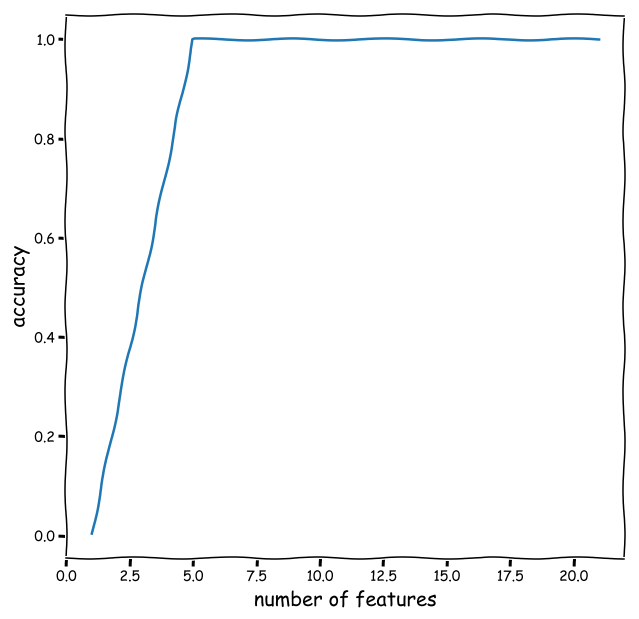

In [73]:
plt.figure(figsize=(10, 10))
plt.plot(n_f, scores, linewidth=2.5)
plt.ylabel(r"accuracy", fontsize=20)
plt.xlabel(r"number of features", fontsize=20)

### Timing check for three methods (blobs data)

K-means

In [0]:
number_of_clusters = 3

for i in [100, 1000, 5000]:
  X, y = make_blobs(n_samples=i, random_state=42, n_features=10)
  %timeit y_pred = KMeans(n_clusters=number_of_clusters, random_state=42).fit_predict(X)

100 loops, best of 3: 14.5 ms per loop
10 loops, best of 3: 25.5 ms per loop
10 loops, best of 3: 46.9 ms per loop


p-Kmeans

In [0]:
def p_kmeans(X, number_of_clusters):
  A = X.T
  AA = A.T @ A
  val, vect = np.linalg.eig(AA)
  x_m_vect = np.argsort(val)[-number_of_clusters:]
  new_X = vect[:, x_m_vect]
  new_X = np.abs(new_X)
  y_pred2 = KMeans(n_clusters=number_of_clusters, random_state=42).fit_predict(new_X)
  return(y_pred2)

for i in [100, 1000, 5000]:
  X, y = make_blobs(n_samples=i, random_state=42, n_features=10)
  %timeit y_pred2 = p_kmeans(X, number_of_clusters)

10 loops, best of 3: 36.1 ms per loop
1 loop, best of 3: 1.46 s per loop
1 loop, best of 3: 1min 8s per loop


p-QR

In [0]:
for i in [100, 1000, 5000]:
  X, y = make_blobs(n_samples=i, random_state=42, n_features=10)
  A = X.T
  %timeit y_pred_qr = PQR_clustering(A, number_of_clusters)

100 loops, best of 3: 6.94 ms per loop
1 loop, best of 3: 206 ms per loop
1 loop, best of 3: 14.7 s per loop


### p-QR for 20newsgroups

number_of_clusters = 2

In [74]:
categories =['rec.motorcycles','rec.sport.baseball']
dataset2 = fetch_20newsgroups(subset='all',
                             shuffle=True, random_state=random_state, categories = categories)
texts = dataset2.data
target = dataset2.target
number_of_clusters = 2

vectorizer = TfidfVectorizer(stop_words='english', max_features=1000, norm = 'l2', max_df = 0.3, min_df = 8) # k means лучше на 5% с 10000 чем с 1000
X = vectorizer.fit_transform(texts).toarray()

In [75]:
A = X.T
y_pred_qr = PQR_clustering(A, number_of_clusters)
v_measure_score(target, y_pred_qr)

0.7708731846509155

In [76]:
y_pred_texts = KMeans(n_clusters=number_of_clusters, random_state=42).fit_predict(X)
v_measure_score(target, y_pred_texts)

0.808339951305998

number_of_clusters = 4

In [77]:
categories =['rec.motorcycles', 'rec.sport.baseball', 'alt.atheism', 'comp.graphics']
dataset2 = fetch_20newsgroups(subset='all',
                             shuffle=True, random_state=random_state, categories = categories)
texts = dataset2.data
target = dataset2.target
number_of_clusters = 4

vectorizer = TfidfVectorizer(stop_words='english', norm = 'l2', max_df = 0.3, min_df = 8)
X = vectorizer.fit_transform(texts).toarray()
A = X.T
y_pred_qr = PQR_clustering(A, number_of_clusters)
v_measure_score(target, y_pred_qr)

0.7547051246420183

In [78]:
y_pred_texts = KMeans(n_clusters=number_of_clusters, random_state=42).fit_predict(X)
v_measure_score(target, y_pred_texts)

0.6734266363809611

number_of_clusters = 20

In [0]:
dataset2 = fetch_20newsgroups(subset='all',
                             shuffle=True, random_state=42)
texts = dataset2.data
target = dataset2.target
number_of_clusters = 20

vectorizer = TfidfVectorizer(stop_words='english', norm = 'l2', max_df = 0.3, min_df = 8)
X = vectorizer.fit_transform(texts).toarray()

A = X.T
y_pred_qr = PQR_clustering(A, number_of_clusters)
v_measure_score(target, y_pred_qr)

0.38067964973580287

In [0]:
y_pred_texts = KMeans(n_clusters=number_of_clusters, random_state=42).fit_predict(X)
v_measure_score(target, y_pred_texts)

0.3533243402768801

We see that p-QR is more stable at shows better results for a bigger amount of clusters.